In [1]:
# ============================
# Cell 1 — Global setup: imports, GPU/dtype, reproducibility, experiment config
# ============================

import os, math, time, random, warnings
import numpy as np

# quiet some noisy warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.*", category=UserWarning)

# numpy bool8 compat (gymnasium sometimes references it)
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

# ----------------------------
# TensorFlow / GPflow setup
# ----------------------------
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # quieter TF logs
# Uncomment for extra determinism (can reduce performance):
# os.environ["TF_DETERMINISTIC_OPS"] = "1"

import tensorflow as tf
import gpflow

# ---- GPU memory growth (prevents TF from grabbing all VRAM) ----
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print("TF version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs:", gpus)

# ----------------------------
# Global experiment config (FAIRNESS LIVES HERE)
# ----------------------------
CFG = dict(
    # runs / episodes
    N_RUNS=5,              # average over runs (different seeds)
    N_EPISODES=4,          # sequential episodes; data accumulates across episodes
    MAX_STEPS=600,         # per-episode time limit

    # online update schedule
    UPDATE_EVERY=40,       # retrain / update cadence (timesteps)
    MIN_UPDATE_BATCH=20,   # require at least this many non-respawn transitions

    # controller fairness
    USE_SAME_MPPI=True,    # all methods use same MPPI parameters + cost
    EXCLUDE_RENDER_TIME=True,
    EXCLUDE_PLOT_TIME=True,

    # GP dtype (MUST be the same for PALSGP / Exact / SVGP)
    USE_FLOAT64_GP=False,  # set True only if you hit numeric issues; keep consistent across all methods

    # sparse size fairness (PALSGP global inducing count == SVGP inducing count)
    M_GLOBAL=256,          # inducing points for PALSGP global + SVGP
    M_LOCAL=64,            # local subset size for PALSGP

    # prediction benchmark (outside MPPI, same query batch across methods)
    PRED_BENCH_N=4096,
    PRED_BENCH_REPS=5,
)

GP_DTYPE = tf.float64 if CFG["USE_FLOAT64_GP"] else tf.float32
NP_DTYPE = np.float64 if CFG["USE_FLOAT64_GP"] else np.float32

gpflow.config.set_default_float(NP_DTYPE)
gpflow.config.set_default_jitter(1e-6)

print("\n=== CONFIG ===")
for k, v in CFG.items():
    print(f"{k}: {v}")
print("GP_DTYPE:", GP_DTYPE.name, "| gpflow.default_float:", gpflow.config.default_float())

# ----------------------------
# Reproducibility helpers
# ----------------------------
def set_global_seed(seed: int):
    """Sets python/numpy/tensorflow seeds (keep identical protocol across methods)."""
    seed = int(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    return seed

# seeds for runs (deterministic)
BASE_SEED = 0
RUN_SEEDS = [BASE_SEED + i for i in range(CFG["N_RUNS"])]

print("\nRUN_SEEDS:", RUN_SEEDS)


/tmp/ipykernel_95337/3999803334.py:12: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not hasattr(np, "bool8"):


TF version: 2.20.0
Built with CUDA: True
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

=== CONFIG ===
N_RUNS: 5
N_EPISODES: 4
MAX_STEPS: 600
UPDATE_EVERY: 40
MIN_UPDATE_BATCH: 20
USE_SAME_MPPI: True
EXCLUDE_RENDER_TIME: True
EXCLUDE_PLOT_TIME: True
USE_FLOAT64_GP: False
M_GLOBAL: 256
M_LOCAL: 64
PRED_BENCH_N: 4096
PRED_BENCH_REPS: 5
GP_DTYPE: float32 | gpflow.default_float: <class 'numpy.float32'>

RUN_SEEDS: [0, 1, 2, 3, 4]


W0000 00:00:1770662148.828000   95337 gpu_device.cc:2431] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [2]:
# ============================
# Cell 2 — Shared environment + feature map + transition→(X,Y) extraction
# (Authoritative for PALSGP / ExactGP / SVGP to ensure fairness)
# ============================

import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit
from gymnasium.utils import seeding

DTYPE_NP = NP_DTYPE  # from Cell 1

# ----------------------------
# Angle helpers (stable deltas)
# ----------------------------
def wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def angle_diff(a_next, a):
    """Smallest signed difference a_next - a in (-pi, pi]."""
    return wrap_pi(a_next - a)

def obs_to_state(obs):
    """
    obs = [x, x_dot, theta, theta_dot]
    Wrap theta to (-pi, pi] for stability / consistent deltas.
    """
    x, xdot, th, thdot = float(obs[0]), float(obs[1]), float(obs[2]), float(obs[3])
    th = wrap_pi(th)
    return x, xdot, th, thdot

# ----------------------------
# GP feature map (D=6)
# ----------------------------
U_MIN, U_MAX = -1.0, 1.0

def state_to_features(x, xdot, theta, thetadot, u,
                      x_scale=2.4, v_scale=3.0, w_scale=8.0,
                      dtype=DTYPE_NP):
    """
    Bounded features:
      [ tanh(x/x_scale),
        tanh(xdot/v_scale),
        sin(theta),
        cos(theta),
        tanh(thetadot/w_scale),
        u ]
    """
    x_feat    = np.tanh(x / x_scale)
    xdot_feat = np.tanh(xdot / v_scale)
    w_feat    = np.tanh(thetadot / w_scale)
    return np.array([x_feat, xdot_feat, np.sin(theta), np.cos(theta), w_feat, float(u)], dtype=dtype)

def batch_state_to_features(S, U,
                            x_scale=2.4, v_scale=3.0, w_scale=8.0,
                            dtype=DTYPE_NP):
    """
    S: (N,4) raw states [x, xdot, theta, thetadot] (theta assumed wrapped)
    U: (N,1) actions in [-1,1]
    returns X: (N,6)
    """
    x      = S[:, 0]
    xdot   = S[:, 1]
    th     = S[:, 2]
    thdot  = S[:, 3]
    u      = U[:, 0]

    X = np.empty((S.shape[0], 6), dtype=dtype)
    X[:, 0] = np.tanh(x / x_scale)
    X[:, 1] = np.tanh(xdot / v_scale)
    X[:, 2] = np.sin(th)
    X[:, 3] = np.cos(th)
    X[:, 4] = np.tanh(thdot / w_scale)
    X[:, 5] = u.astype(dtype, copy=False)
    return X

# ----------------------------
# Custom Continuous CartPole Swing-Up (same as your current notebook)
# ----------------------------
class ContinuousCartPoleSwingUpEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array", "human"], "render_fps": 50}

    def __init__(self, render_mode=None, start_down=True):
        super().__init__()

        # physics
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5
        self.polemass_length = self.masspole * self.length

        # control
        self.force_mag = 30.0
        self.tau = 0.02
        self.min_action = -1.0
        self.max_action = 1.0

        # track limits
        self.x_threshold = 2.4

        # reset mode
        self.start_down = bool(start_down)

        # render (we keep render stubbed; we’ll add a pure-PIL renderer later)
        self.render_mode = render_mode
        self.state = None
        self.np_random = None
        self.seed()

        # spaces
        high = np.array(
            [self.x_threshold * 2,
             np.finfo(np.float32).max,
             np.finfo(np.float32).max,
             np.finfo(np.float32).max],
            dtype=np.float32,
        )

        self.action_space = spaces.Box(
            low=np.array([self.min_action], dtype=np.float32),
            high=np.array([self.max_action], dtype=np.float32),
            shape=(1,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta * costheta / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        action = np.asarray(action, dtype=np.float32).reshape(1,)
        assert self.action_space.contains(action), f"{action} invalid"

        u = float(action[0])
        force = self.force_mag * u

        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state

        terminated = bool(x < -self.x_threshold or x > self.x_threshold)
        truncated = False  # TimeLimit wrapper handles truncation

        reward = (
            +1.0 * math.cos(theta)
            -0.01 * (x * x)
            -0.001 * (x_dot * x_dot)
            -0.001 * (theta_dot * theta_dot)
            -0.001 * (u * u)
        )

        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        info = dict(x=x, x_dot=x_dot, theta=theta, theta_dot=theta_dot, u=u)
        return obs, float(reward), terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        x = float(self.np_random.uniform(low=-0.05, high=0.05))
        x_dot = float(self.np_random.uniform(low=-0.05, high=0.05))
        theta_dot = float(self.np_random.uniform(low=-0.05, high=0.05))

        if self.start_down:
            theta = float(math.pi + self.np_random.uniform(low=-0.10, high=0.10))
        else:
            theta = float(self.np_random.uniform(low=-0.10, high=0.10))

        self.state = (x, x_dot, theta, theta_dot)
        obs = np.array(self.state, dtype=np.float32)
        info = {}
        return obs, info

    def render(self):
        return None

    def close(self):
        return None

# ----------------------------
# Edge respawn wrapper (training fairness: respawn transitions are SKIPPED)
# ----------------------------
class EdgeRespawnWrapper(gym.Wrapper):
    def __init__(self, env, respawn_penalty=-2.0, reset_seed_mode="random", seed=0):
        super().__init__(env)
        self.respawn_penalty = float(respawn_penalty)
        self.reset_seed_mode = str(reset_seed_mode)
        self._rng = np.random.default_rng(seed)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)
        return self.env.reset(seed=seed, options=options)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        if terminated:
            info = dict(info)
            info["respawned"] = True
            reward = float(reward) + self.respawn_penalty

            seed = int(self._rng.integers(0, 10**9)) if self.reset_seed_mode == "random" else None
            obs, _ = self.env.reset(seed=seed)

            terminated = False
            truncated = False

        return obs, float(reward), bool(terminated), bool(truncated), info

# ----------------------------
# Factory (one place to control episode length + respawn behavior)
# ----------------------------
def make_env(
    render_mode=None,
    seed=0,
    max_episode_steps=None,
    start_down=True,
    edge_respawn=True,
    respawn_penalty=-2.0,
):
    if max_episode_steps is None:
        max_episode_steps = int(CFG["MAX_STEPS"])
    env = ContinuousCartPoleSwingUpEnv(render_mode=render_mode, start_down=start_down)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if edge_respawn:
        env = EdgeRespawnWrapper(env, respawn_penalty=respawn_penalty, seed=seed)
    env.reset(seed=seed)
    return env

# ----------------------------
# Transition → (X,Y) extraction (the ONLY definition all methods use)
# ----------------------------
def transition_to_xy(obs, action, obs_next, info):
    """
    Returns:
      (x_row, y_dx, y_dxdot, y_dth, y_dthdot, keep)
    where:
      x_row is (6,) features at current state + action
      y_* are scalar deltas over one step in RAW state coords
      keep=False iff this transition should be excluded from training
        (e.g., edge respawn step)
    """
    if info is not None and bool(info.get("respawned", False)):
        return None, None, None, None, None, False

    x, xdot, th, thdot = obs_to_state(obs)
    xn, xd_n, th_n, thd_n = obs_to_state(obs_next)

    u = float(np.asarray(action).reshape(-1)[0])

    x_row = state_to_features(x, xdot, th, thdot, u, dtype=DTYPE_NP)

    y_dx     = (xn   - x)
    y_dxdot  = (xd_n - xdot)
    y_dth    = angle_diff(th_n, th)
    y_dthdot = (thd_n - thdot)

    return x_row, y_dx, y_dxdot, y_dth, y_dthdot, True

# ----------------------------
# Sanity check
# ----------------------------
set_global_seed(0)
env = make_env(render_mode=None, seed=0, start_down=True, edge_respawn=True)
obs, _ = env.reset(seed=0)

a = env.action_space.sample()
obs2, r, term, trunc, info = env.step(a)
xrow, ydx, ydxd, ydth, ydthd, keep = transition_to_xy(obs, a, obs2, info)

print("✅ Env + feature map ready")
print("obs:", obs)
print("action:", a)
print("respawned?", bool(info.get("respawned", False)))
print("X row shape:", None if xrow is None else xrow.shape, "| keep:", keep)
env.close()


✅ Env + feature map ready
obs: [ 0.01369617 -0.02302133  3.0448983  -0.04590265]
action: [-0.7097042]
respawned? False
X row shape: (6,) | keep: True


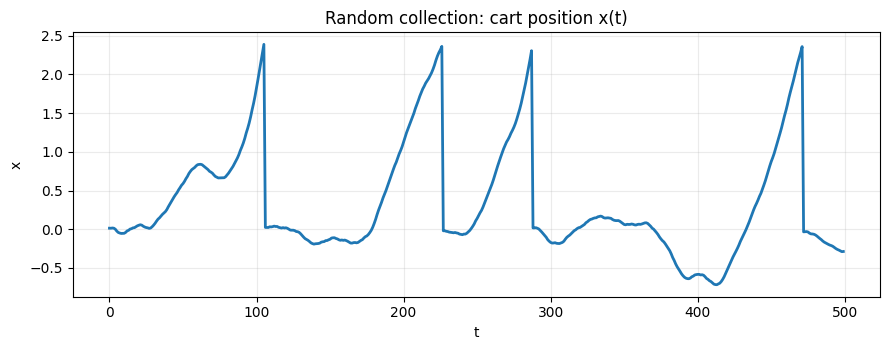

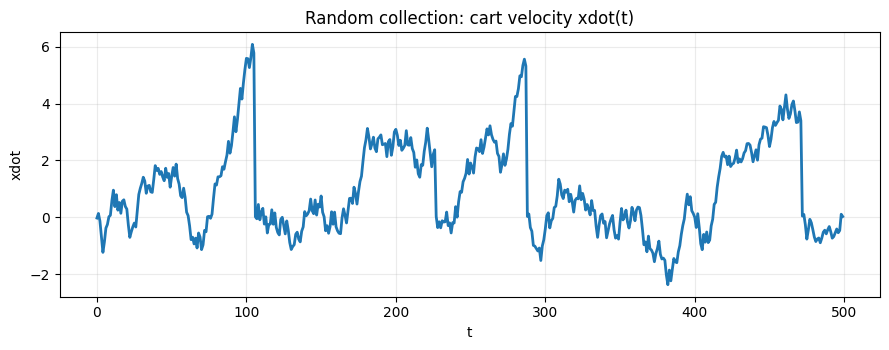

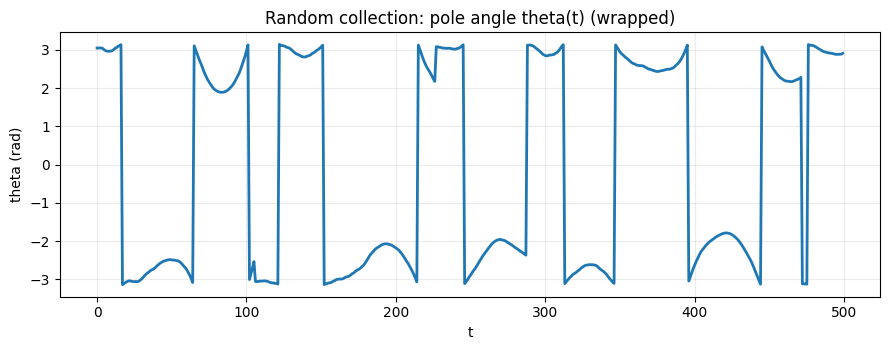

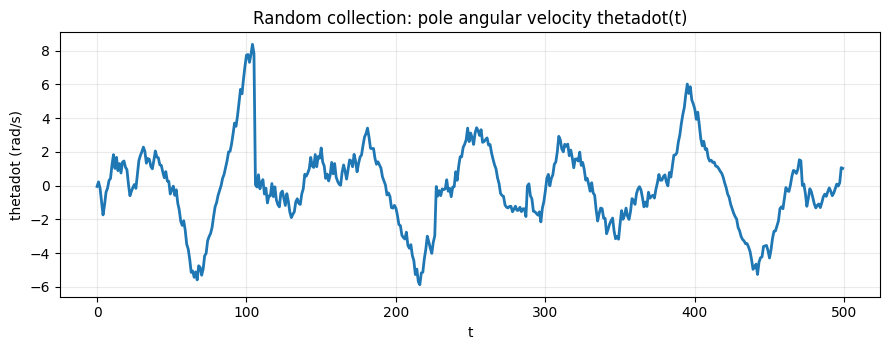

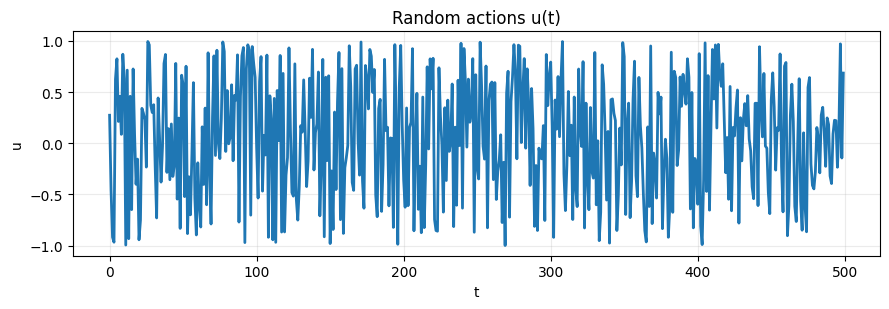

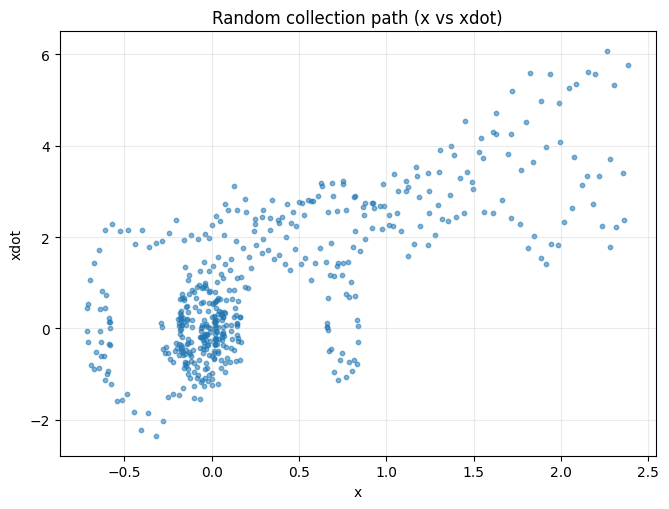

Collected X0 shape: (496, 6)  (6D features)
Collected Y0 shape: (496, 4)  (4D deltas)
Kept=496  Dropped(respawn)=4  Resets=0


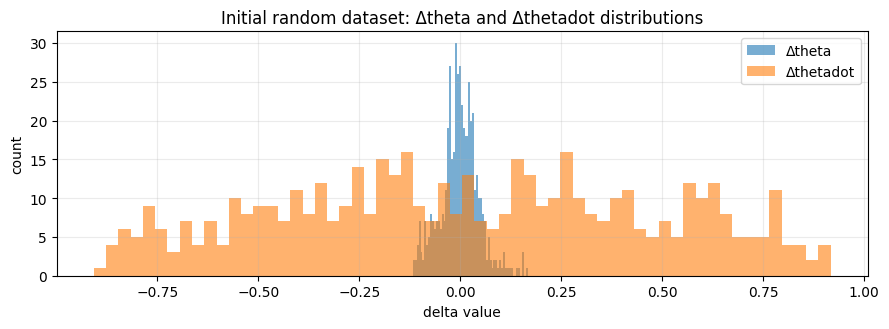

In [3]:
# ============================
# Cell 2b — Render RANDOM collection path (and collect initial X0, Y0)
# Pure-PIL renderer + JS animation (no env.render / pygame)
# IMPORTANT: drops transitions with info["respawned"]=True
# ============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from PIL import Image, ImageDraw

# ------------------------------------------------------------
# Pure-PIL renderer: (x, theta) -> RGB frame
# ------------------------------------------------------------
def render_cartpole_frame_from_state(
    x, theta,
    x_threshold=2.4,
    W=720, H=450,
    cart_width=70,
    cart_height=35,
    pole_length_px=160,
    pole_width=10,
):
    """
    Minimal CartPole render (rgb uint8) from state.
    theta: 0=upright, pi=down (standard)
    """
    img = Image.new("RGB", (W, H), (245, 245, 245))
    dr = ImageDraw.Draw(img)

    # track line
    y_track = int(0.72 * H)
    dr.line([(0, y_track), (W, y_track)], fill=(210, 210, 210), width=4)

    # map x -> screen px
    margin = 40
    x_clamped = float(np.clip(x, -x_threshold, x_threshold))
    x_norm = (x_clamped + x_threshold) / (2 * x_threshold)  # [0,1]
    cx = int(margin + x_norm * (W - 2 * margin))
    cy = y_track - cart_height // 2

    # cart
    x0 = cx - cart_width // 2
    y0 = cy - cart_height // 2
    x1 = cx + cart_width // 2
    y1 = cy + cart_height // 2
    dr.rounded_rectangle([x0, y0, x1, y1], radius=8,
                         fill=(60, 90, 160), outline=(30, 30, 30), width=2)

    # axle point near top of cart
    ax = cx
    ay = y0 + 6

    # pole endpoint: dx=L*sin(theta), dy=-L*cos(theta)
    dx = pole_length_px * float(np.sin(theta))
    dy = -pole_length_px * float(np.cos(theta))
    px = ax + dx
    py = ay + dy

    dr.line([(ax, ay), (px, py)], fill=(180, 50, 50), width=pole_width)

    # axle circle
    r = 8
    dr.ellipse([ax - r, ay - r, ax + r, ay + r], fill=(30, 30, 30))
    return np.asarray(img, dtype=np.uint8)

# ------------------------------------------------------------
# Random collection (rendered)
# ------------------------------------------------------------
def collect_random_transitions_rendered_cartpole(
    n_steps=500,
    seed=0,
    max_episode_steps=500,
    start_down=True,
    # rendering
    record_rgb=True,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    # env behavior
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=False,
):
    rng = np.random.default_rng(seed)

    env_vis = make_env(
        render_mode=None,   # we render ourselves
        seed=seed,
        max_episode_steps=max_episode_steps,
        start_down=start_down,
        edge_respawn=edge_respawn,
        respawn_penalty=respawn_penalty,
    )

    obs, info = env_vis.reset(seed=seed)
    x, xdot, th, thdot = obs_to_state(obs)

    X_list, Y_list = [], []

    traj_x, traj_xdot, traj_th, traj_thdot, traj_u = [], [], [], [], []
    frames = []
    dropped = 0
    resets = 0

    for t in range(int(n_steps)):
        u = float(rng.uniform(U_MIN, U_MAX))
        a = np.array([u], dtype=np.float32)

        obs2, reward, terminated, truncated, info = env_vis.step(a)
        x2, xdot2, th2, thdot2 = obs_to_state(obs2)

        respawned = bool(isinstance(info, dict) and info.get("respawned", False))
        if respawned and drop_respawn_transitions:
            dropped += 1
        else:
            # Use the SAME authoritative transition definition
            xrow, ydx, ydxd, ydth, ydthd, keep = transition_to_xy(obs, a, obs2, info)
            if keep:
                X_list.append(xrow)
                Y_list.append([ydx, ydxd, ydth, ydthd])

        traj_x.append(x)
        traj_xdot.append(xdot)
        traj_th.append(th)
        traj_thdot.append(thdot)
        traj_u.append(u)

        if record_rgb and (t % int(frame_stride) == 0):
            W, H = int(resize[0]), int(resize[1])
            frame = render_cartpole_frame_from_state(x2, th2, x_threshold=2.4, W=W, H=H)
            frames.append(frame)

        # advance
        obs = obs2
        x, xdot, th, thdot = x2, xdot2, th2, thdot2

        if terminated or truncated:
            resets += 1
            obs, info = env_vis.reset(seed=int(seed + 123 + t))
            x, xdot, th, thdot = obs_to_state(obs)
            if verbose:
                print(f"[t={t:04d}] reset (terminated={terminated}, truncated={truncated})")

    env_vis.close()

    X0 = np.asarray(X_list, dtype=NP_DTYPE)
    Y0 = np.asarray(Y_list, dtype=NP_DTYPE).reshape(-1, 4)

    traj = dict(
        x=np.asarray(traj_x, dtype=np.float64),
        xdot=np.asarray(traj_xdot, dtype=np.float64),
        theta=np.asarray(traj_th, dtype=np.float64),
        thetadot=np.asarray(traj_thdot, dtype=np.float64),
        u=np.asarray(traj_u, dtype=np.float64),
        dropped_respawn=int(dropped),
        resets=int(resets),
        steps=int(n_steps),
        kept=int(X0.shape[0]),
    )

    # ----------------------------
    # 1) show animation
    # ----------------------------
    if record_rgb and len(frames) > 0:
        fig = plt.figure(figsize=(resize[0] / 100, resize[1] / 100), dpi=100)
        plt.axis("off")
        im = plt.imshow(frames[0])

        def animate_fn(i):
            im.set_data(frames[i])
            return [im]

        ani = animation.FuncAnimation(
            fig, animate_fn,
            frames=len(frames),
            interval=1000 / float(fps),
            blit=True
        )
        plt.close(fig)
        display(HTML(ani.to_jshtml()))
    elif record_rgb:
        print("⚠️ No frames collected (check frame_stride / resize).")

    # ----------------------------
    # 2) trajectory plots
    # ----------------------------
    tgrid = np.arange(len(traj["x"]))

    def _plot(y, title, ylabel, figsize=(9, 3.6)):
        plt.figure(figsize=figsize)
        plt.plot(tgrid, y, linewidth=2)
        plt.xlabel("t"); plt.ylabel(ylabel)
        plt.title(title)
        plt.grid(True, alpha=0.25)
        plt.tight_layout()
        plt.show()

    _plot(traj["x"],      "Random collection: cart position x(t)", "x")
    _plot(traj["xdot"],   "Random collection: cart velocity xdot(t)", "xdot")
    _plot(traj["theta"],  "Random collection: pole angle theta(t) (wrapped)", "theta (rad)")
    _plot(traj["thetadot"], "Random collection: pole angular velocity thetadot(t)", "thetadot (rad/s)")
    _plot(traj["u"],      "Random actions u(t)", "u", figsize=(9, 3.2))

    plt.figure(figsize=(6.8, 5.2))
    plt.scatter(traj["x"], traj["xdot"], s=10, alpha=0.55)
    plt.xlabel("x"); plt.ylabel("xdot")
    plt.title("Random collection path (x vs xdot)")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

    print("Collected X0 shape:", X0.shape, " (6D features)")
    print("Collected Y0 shape:", Y0.shape, " (4D deltas)")
    print(f"Kept={traj['kept']}  Dropped(respawn)={traj['dropped_respawn']}  Resets={traj['resets']}")

    return X0, Y0, frames, traj

# ---- run it ----
SEED = 0
X0, Y0, frames0, traj0 = collect_random_transitions_rendered_cartpole(
    n_steps=500,
    seed=SEED,
    max_episode_steps=500,
    start_down=True,
    record_rgb=True,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=False,
)

# Optional quick sanity histograms
plt.figure(figsize=(9, 3.4))
plt.hist(Y0[:, 2], bins=60, alpha=0.6, label="Δtheta")
plt.hist(Y0[:, 3], bins=60, alpha=0.6, label="Δthetadot")
plt.title("Initial random dataset: Δtheta and Δthetadot distributions")
plt.xlabel("delta value"); plt.ylabel("count")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()


In [4]:
# ============================
# Cell 3 — Shared MPPI controller + cost + success criteria + logging harness
# (Method-agnostic: PALSGP / ExactGP / SVGP must plug into the SAME interface)
# ============================

import time
import numpy as np
import tensorflow as tf

# ----------------------------
# MPPI config (fair across all methods)
# ----------------------------
MPPI = dict(
    H=45,            # horizon
    K=128,      # rollouts
    ITER=3,          # MPPI refinement iterations per control step
    LAMBDA=1.0,      # temperature
    SIGMA=0.35,      # exploration noise std on action
    U_MIN=-1.0,
    U_MAX=1.0,
)

# Cost weights (same for all)
COST = dict(
    W_X=0.10,
    W_XDOT=0.01,
    W_TH=1.00,
    W_THDOT=0.01,
    W_U=0.001,
    # uncertainty bonus (optional; set to 0 for "pure" mean-dynamics planning)
    W_UNC=0.0,
)

# Success criteria (same for all)
SUCCESS = dict(
    TH_DEG=12.0,       # |theta| <= this
    THDOT=1.0,         # |thetadot| <= this
    X=0.50,            # |x| <= this
    HOLD_STEPS=25,     # consecutive steps to count as success
)

TH_THRESH = np.deg2rad(SUCCESS["TH_DEG"])

# ----------------------------
# TF helpers (GPU-friendly rollout)
# ----------------------------
X_SCALE = tf.constant(2.4, dtype=GP_DTYPE)
V_SCALE = tf.constant(3.0, dtype=GP_DTYPE)
W_SCALE = tf.constant(8.0, dtype=GP_DTYPE)
PI = tf.constant(np.pi, dtype=GP_DTYPE)
TWO_PI = tf.constant(2.0 * np.pi, dtype=GP_DTYPE)

@tf.function
def tf_wrap_pi(a):
    return tf.math.floormod(a + PI, TWO_PI) - PI

@tf.function
def tf_state_to_features(S, U):
    """
    S: (N,4) [x, xdot, theta, thetadot]  (theta can be any; we wrap)
    U: (N,1) actions
    returns X: (N,6) features identical to Cell 2 mapping
    """
    x     = tf.cast(S[:, 0], GP_DTYPE)
    xdot  = tf.cast(S[:, 1], GP_DTYPE)
    th    = tf_wrap_pi(tf.cast(S[:, 2], GP_DTYPE))
    thdot = tf.cast(S[:, 3], GP_DTYPE)
    u     = tf.cast(U[:, 0], GP_DTYPE)

    x_feat    = tf.tanh(x / X_SCALE)
    xdot_feat = tf.tanh(xdot / V_SCALE)
    w_feat    = tf.tanh(thdot / W_SCALE)

    X = tf.stack([x_feat, xdot_feat, tf.sin(th), tf.cos(th), w_feat, u], axis=1)
    return X

@tf.function
def tf_step_state(S, dS):
    """
    S, dS: (N,4)
    next: theta wrapped
    """
    x     = S[:, 0] + dS[:, 0]
    xdot  = S[:, 1] + dS[:, 1]
    th    = tf_wrap_pi(S[:, 2] + dS[:, 2])
    thdot = S[:, 3] + dS[:, 3]
    return tf.stack([x, xdot, th, thdot], axis=1)

@tf.function
def tf_running_cost(S, U, unc_std=None):
    """
    S: (N,4) rollout states
    U: (N,1) rollout actions
    unc_std: (N,4) optional predicted std of deltas; used as exploration penalty/bonus
    """
    x     = S[:, 0]
    xdot  = S[:, 1]
    th    = tf_wrap_pi(S[:, 2])
    thdot = S[:, 3]
    u     = U[:, 0]

    c = (COST["W_X"]    * x*x +
         COST["W_XDOT"] * xdot*xdot +
         COST["W_TH"]   * th*th +
         COST["W_THDOT"]* thdot*thdot +
         COST["W_U"]    * u*u)

    if (unc_std is not None) and (COST["W_UNC"] != 0.0):
        # simple scalar summary: sum stds over 4 outputs
        c = c + tf.cast(COST["W_UNC"], GP_DTYPE) * tf.reduce_sum(unc_std, axis=1)
    return c

# ----------------------------
# Required model interface (ALL methods must implement this)
# ----------------------------
class DynamicsModelBundle:
    """
    Implementations for PALSGP / ExactGP / SVGP must provide:
      predict_delta(X) -> (mu, std)
        mu:  (N,4) delta means [dx, dxdot, dtheta, dthetadot]
        std: (N,4) delta stds  (can be zeros if not available)
    Must accept TF tensors and return TF tensors on same device.
    """
    def predict_delta(self, X: tf.Tensor):
        raise NotImplementedError

# ----------------------------
# MPPI planner (stateless noise for fairness across methods)
# ----------------------------
@tf.function
def mppi_plan_one_step(model: DynamicsModelBundle,
                       s0: tf.Tensor,
                       u_nom: tf.Tensor,
                       seed_pair: tf.Tensor):
    """
    s0: (1,4)
    u_nom: (H,1)
    seed_pair: (2,) int32 for stateless RNG
    returns:
      u0: scalar action
      u_nom_new: (H,1) updated nominal sequence
    """
    H = int(MPPI["H"]); K = int(MPPI["K"])
    lam = tf.cast(MPPI["LAMBDA"], GP_DTYPE)
    sigma = tf.cast(MPPI["SIGMA"], GP_DTYPE)
    umin = tf.cast(MPPI["U_MIN"], GP_DTYPE)
    umax = tf.cast(MPPI["U_MAX"], GP_DTYPE)

    # shape helpers
    s0K = tf.repeat(tf.cast(s0, GP_DTYPE), repeats=K, axis=0)  # (K,4)
    u_nom = tf.cast(u_nom, GP_DTYPE)                           # (H,1)

    # MPPI refinement iterations
    for it in tf.range(int(MPPI["ITER"])):
        # eps: (K,H,1)
        eps = tf.random.stateless_normal(shape=(K, H, 1), seed=seed_pair + tf.stack([0, it]),
                                         dtype=GP_DTYPE)
        U = tf.clip_by_value(u_nom[None, :, :] + sigma * eps, umin, umax)  # (K,H,1)

        # rollout
        S = s0K
        total_cost = tf.zeros((K,), dtype=GP_DTYPE)

        for t in tf.range(H):
            Ut = U[:, t, :]                 # (K,1)
            Xt = tf_state_to_features(S, Ut)  # (K,6)
            mu, std = model.predict_delta(Xt) # (K,4), (K,4)
            S = tf_step_state(S, mu)          # (K,4)
            total_cost += tf_running_cost(S, Ut, std)

        # weights
        cmin = tf.reduce_min(total_cost)
        w = tf.exp(-(total_cost - cmin) / lam)     # (K,)
        w = w / (tf.reduce_sum(w) + 1e-12)

        # weighted update in epsilon space
        dU = tf.reduce_sum(w[:, None, None] * (sigma * eps), axis=0)  # (H,1)
        u_nom = tf.clip_by_value(u_nom + dU, umin, umax)

    u0 = u_nom[0, 0]
    # shift warm start
    u_nom_new = tf.concat([u_nom[1:, :], u_nom[-1:, :]], axis=0)
    return u0, u_nom_new

# ----------------------------
# Episode runner (shared; method supplies model + update() later)
# ----------------------------
def new_episode_log():
    return dict(
        step=[],
        episode=[],
        reward=[],
        success=[],
        mppi_time_s=[],
        # online update logs (filled later by each method):
        did_update=[],
        n_batch=[],
        n_data_total=[],
        t_train_s=[],
        t_predbench_s=[],
    )

def check_success(obs, hold_counter):
    x, xdot, th, thdot = obs_to_state(obs)
    good = (abs(th) <= TH_THRESH) and (abs(thdot) <= SUCCESS["THDOT"]) and (abs(x) <= SUCCESS["X"])
    hold_counter = hold_counter + 1 if good else 0
    return hold_counter, (hold_counter >= SUCCESS["HOLD_STEPS"])

def run_one_episode_with_mppi(model: DynamicsModelBundle,
                             env,
                             episode_id: int,
                             global_step_offset: int,
                             run_seed: int,
                             max_steps=None,
                             log=None):
    """
    Runs ONE episode using MPPI + provided dynamics model.
    This function does NOT update the model; later cells will wrap this with online update logic.
    """
    if max_steps is None:
        max_steps = int(CFG["MAX_STEPS"])
    if log is None:
        log = new_episode_log()

    obs, _ = env.reset(seed=run_seed + 1000 * episode_id)
    hold = 0
    success = False

    u_nom = tf.zeros((MPPI["H"], 1), dtype=GP_DTYPE)

    for t in range(max_steps):
        s = np.array(obs_to_state(obs), dtype=NP_DTYPE).reshape(1, 4)
        s_tf = tf.convert_to_tensor(s, dtype=GP_DTYPE)

        # stateless RNG seed per (run, global step) => identical MPPI noise across methods
        gstep = int(global_step_offset + t)
        seed_pair = tf.constant([int(run_seed), int(gstep)], dtype=tf.int32)

        t0 = time.perf_counter()
        u0, u_nom = mppi_plan_one_step(model, s_tf, u_nom, seed_pair)
        t1 = time.perf_counter()

        a = np.array([float(u0.numpy())], dtype=np.float32)
        obs2, r, term, trunc, info = env.step(a)

        hold, success = check_success(obs2, hold)
        log["step"].append(gstep)
        log["episode"].append(int(episode_id))
        log["reward"].append(float(r))
        log["success"].append(bool(success))
        log["mppi_time_s"].append(float(t1 - t0))

        # placeholders: filled by online update wrapper later
        log["did_update"].append(False)
        log["n_batch"].append(0)
        log["n_data_total"].append(0)
        log["t_train_s"].append(0.0)
        log["t_predbench_s"].append(0.0)

        obs = obs2
        if success:
            break

    return log, success, (t + 1)

print("✅ MPPI + shared runner ready (model-agnostic).")


✅ MPPI + shared runner ready (model-agnostic).


W0000 00:00:1770662268.677578   95337 gpu_device.cc:2431] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1770662268.778726   95337 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10560 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5080, pci bus id: 0000:01:00.0, compute capability: 12.0


In [5]:
# ============================
# Cell 4 — Shared online-data stream + update scheduler + prediction-time benchmark
# (Still method-agnostic; all methods must use these utilities for fairness)
# ============================

import time
import numpy as np
import tensorflow as tf

# ----------------------------
# Online dataset (accumulates across episodes)
# ----------------------------
class OnlineDataset:
    """
    Stores cumulative (X, Y) across episodes. Used for:
      - ExactGP: refit on full data (or window, if you choose later)
      - SVGP: continue training on accumulated data
      - PALSGP: stream updates (still useful to log N_total fairly)
    """
    def __init__(self, x_dim=6, y_dim=4, dtype=NP_DTYPE):
        self.x_dim = int(x_dim)
        self.y_dim = int(y_dim)
        self.dtype = dtype
        self.X = np.zeros((0, self.x_dim), dtype=dtype)
        self.Y = np.zeros((0, self.y_dim), dtype=dtype)

    def append(self, Xnew, Ynew):
        Xnew = np.asarray(Xnew, dtype=self.dtype)
        Ynew = np.asarray(Ynew, dtype=self.dtype)
        assert Xnew.ndim == 2 and Xnew.shape[1] == self.x_dim
        assert Ynew.ndim == 2 and Ynew.shape[1] == self.y_dim
        if Xnew.shape[0] == 0:
            return
        self.X = np.concatenate([self.X, Xnew], axis=0)
        self.Y = np.concatenate([self.Y, Ynew], axis=0)

    @property
    def n(self):
        return int(self.X.shape[0])

# ----------------------------
# Update buffer (collects transitions between updates)
# ----------------------------
class UpdateBuffer:
    def __init__(self, min_batch=10):
        self.min_batch = int(min_batch)
        self.Xbuf = []
        self.Ybuf = []

    def push_transition(self, x_row, y_row):
        self.Xbuf.append(x_row)
        self.Ybuf.append(y_row)

    def ready(self, t_step_1based):
        # Update cadence: every UPDATE_EVERY steps
        if (t_step_1based % int(CFG["UPDATE_EVERY"])) != 0:
            return False
        return (len(self.Xbuf) >= self.min_batch)

    def pop_batch(self):
        if len(self.Xbuf) == 0:
            return None, None
        Xnew = np.asarray(self.Xbuf, dtype=NP_DTYPE)
        Ynew = np.asarray(self.Ybuf, dtype=NP_DTYPE)
        self.Xbuf, self.Ybuf = [], []
        return Xnew, Ynew

# ----------------------------
# Prediction benchmark queries (fixed per run for fairness)
# ----------------------------
def make_predbench_queries(run_seed: int, n=4096, d=6):
    """
    Fixed query set used to benchmark pure prediction cost.
    Same for all methods within a run.
    """
    rng = np.random.default_rng(int(run_seed) + 12345)
    # Use a mild normal cloud; feature space is already bounded-ish by tanh/sin/cos
    Xq = rng.normal(size=(int(n), int(d))).astype(NP_DTYPE)
    return Xq

def median_time_s(fn, reps=5, warmup=1):
    # warmup
    for _ in range(int(warmup)):
        fn()
    ts = []
    for _ in range(int(reps)):
        t0 = time.perf_counter()
        fn()
        ts.append(time.perf_counter() - t0)
    return float(np.median(ts))

def bench_predict_time(model: DynamicsModelBundle, Xq_np: np.ndarray, reps=None):
    """
    Benchmarks model.predict_delta() on a fixed batch, returning median seconds.
    Uses TF tensors to measure device execution.
    """
    if reps is None:
        reps = int(CFG["PRED_BENCH_REPS"])
    Xq_tf = tf.convert_to_tensor(np.asarray(Xq_np, dtype=NP_DTYPE), dtype=GP_DTYPE)

    @tf.function
    def _call():
        mu, std = model.predict_delta(Xq_tf)
        # force materialization to avoid lazy behavior
        return tf.reduce_sum(mu) + tf.reduce_sum(std)

    # Ensure graph is traced once
    _ = _call()

    return median_time_s(lambda: _call().numpy(), reps=reps, warmup=1)

# ----------------------------
# Shared online-runner with updates (method supplies "trainer" callbacks)
# ----------------------------
class OnlineTrainer:
    """
    Method-specific trainers must implement:
      - build_model_from_initial_data(dataset)  (optional; can be no-op)
      - update_model(dataset, Xnew, Ynew) -> train_time_s
      - get_model_bundle() -> DynamicsModelBundle (for MPPI)
      - after_episode_hook(dataset) (optional; for PALSGP anchor refresh etc.)
    """
    def build_model_from_initial_data(self, dataset: OnlineDataset):
        return None

    def update_model(self, dataset: OnlineDataset, Xnew: np.ndarray, Ynew: np.ndarray) -> float:
        raise NotImplementedError

    def get_model_bundle(self) -> DynamicsModelBundle:
        raise NotImplementedError

    def after_episode_hook(self, dataset: OnlineDataset):
        return None

def run_multi_episode_online(trainer: OnlineTrainer,
                            run_seed: int,
                            start_down=True,
                            edge_respawn=True):
    """
    Runs CFG["N_EPISODES"] sequential episodes.
    Data accumulates across episodes; online updates happen every UPDATE_EVERY steps.
    Returns:
      log (per-step, with per-update training/pred timings stored on update steps)
      dataset (final accumulated)
      success_list, steps_list
    """
    set_global_seed(run_seed)

    dataset = OnlineDataset(x_dim=6, y_dim=4, dtype=NP_DTYPE)
    Xq_bench = make_predbench_queries(run_seed, n=CFG["PRED_BENCH_N"], d=6)

    log = new_episode_log()
    success_list, steps_list = [], []

    global_offset = 0

    for ep in range(int(CFG["N_EPISODES"])):
        env = make_env(render_mode=None, seed=run_seed + 1000 * ep,
                       max_episode_steps=int(CFG["MAX_STEPS"]),
                       start_down=start_down, edge_respawn=edge_respawn)

        # buffer for *this episode's* online updates
        ubuf = UpdateBuffer(min_batch=int(CFG["MIN_UPDATE_BATCH"]))

        # (optional) build model on current accumulated dataset
        trainer.build_model_from_initial_data(dataset)
        model = trainer.get_model_bundle()

        obs, _ = env.reset(seed=run_seed + 1000 * ep)
        hold = 0
        success = False
        u_nom = tf.zeros((MPPI["H"], 1), dtype=GP_DTYPE)

        for t in range(int(CFG["MAX_STEPS"])):
            gstep = int(global_offset + t)

            # plan
            s = np.array(obs_to_state(obs), dtype=NP_DTYPE).reshape(1, 4)
            s_tf = tf.convert_to_tensor(s, dtype=GP_DTYPE)
            seed_pair = tf.constant([int(run_seed), int(gstep)], dtype=tf.int32)

            t0 = time.perf_counter()
            u0, u_nom = mppi_plan_one_step(model, s_tf, u_nom, seed_pair)
            t1 = time.perf_counter()

            a = np.array([float(u0.numpy())], dtype=np.float32)
            obs2, r, term, trunc, info = env.step(a)

            # record transition into buffers (skip respawned)
            xrow, ydx, ydxd, ydth, ydthd, keep = transition_to_xy(obs, a, obs2, info)
            if keep:
                yrow = np.array([ydx, ydxd, ydth, ydthd], dtype=NP_DTYPE)
                ubuf.push_transition(xrow, yrow)

            # success check
            hold, success = check_success(obs2, hold)

            # step log (defaults)
            log["step"].append(gstep)
            log["episode"].append(ep)
            log["reward"].append(float(r))
            log["success"].append(bool(success))
            log["mppi_time_s"].append(float(t1 - t0))

            did_update = False
            n_batch = 0
            n_total = dataset.n
            t_train = 0.0
            t_pred = 0.0

            # online update trigger
            if ubuf.ready(t_step_1based=t + 1):
                Xnew, Ynew = ubuf.pop_batch()
                if Xnew is not None and Xnew.shape[0] > 0:
                    did_update = True
                    n_batch = int(Xnew.shape[0])

                    # accumulate data first (so ExactGP can refit on full data size)
                    dataset.append(Xnew, Ynew)
                    n_total = dataset.n

                    # train/update timing
                    t_tr0 = time.perf_counter()
                    _ = trainer.update_model(dataset, Xnew, Ynew)
                    t_tr1 = time.perf_counter()
                    t_train = float(t_tr1 - t_tr0)

                    # refresh model bundle after update
                    model = trainer.get_model_bundle()

                    # prediction benchmark timing
                    t_pred = bench_predict_time(model, Xq_bench, reps=CFG["PRED_BENCH_REPS"])

            log["did_update"].append(bool(did_update))
            log["n_batch"].append(int(n_batch))
            log["n_data_total"].append(int(n_total))
            log["t_train_s"].append(float(t_train))
            log["t_predbench_s"].append(float(t_pred))

            obs = obs2
            if success:
                break

        steps = t + 1
        success_list.append(bool(success))
        steps_list.append(int(steps))

        env.close()

        # allow trainer to do end-of-episode housekeeping if needed
        trainer.after_episode_hook(dataset)

        global_offset += int(CFG["MAX_STEPS"])

    return log, dataset, success_list, steps_list

print("✅ Online data + update scheduler + pred-time benchmark harness ready.")


✅ Online data + update scheduler + pred-time benchmark harness ready.


In [6]:
# ============================
# Cell 5 — Exact GP baseline (GPflow GPR), multi-output as 4 independent GPRs
# Plugs into OnlineTrainer + DynamicsModelBundle from Cells 3–4
# ============================

import copy
import numpy as np
import tensorflow as tf
import gpflow

# ----------------------------
# Shared kernel / noise policy (FAIRNESS)
# ----------------------------
MODEL_CFG = dict(
    KERNEL="SE_ARD",          # SquaredExponential with ARD lengthscales
    NOISE_VAR=1e-3,           # fixed Gaussian likelihood variance for all outputs
    FREEZE_HYPERS=True,       # keep kernel+noise fixed during online updates (same policy for all methods)
    MIN_INIT_DATA=200,        # if dataset smaller, use prior (zero dynamics) until enough data
)

def make_shared_kernel_ard(d_in=6):
    # NOTE: we must deepcopy per-output so they don't share parameters unintentionally.
    k = gpflow.kernels.SquaredExponential(
        lengthscales=np.ones((d_in,), dtype=NP_DTYPE),
        variance=np.array(1.0, dtype=NP_DTYPE),
    )
    return k

class PriorZeroDynamicsBundle(DynamicsModelBundle):
    """Fallback model before enough data exists: predicts zero deltas with constant std."""
    def __init__(self, std=0.5):
        self._std = tf.cast(std, GP_DTYPE)

    @tf.function
    def predict_delta(self, X: tf.Tensor):
        n = tf.shape(X)[0]
        mu  = tf.zeros((n, 4), dtype=GP_DTYPE)
        std = tf.ones((n, 4), dtype=GP_DTYPE) * self._std
        return mu, std

# ----------------------------
# Exact GP dynamics bundle
# ----------------------------
class ExactGPDynamicsBundle(DynamicsModelBundle):
    def __init__(self, m_dx, m_dxdot, m_dth, m_dthdot):
        self.m_dx = m_dx
        self.m_dxdot = m_dxdot
        self.m_dth = m_dth
        self.m_dthdot = m_dthdot

    @tf.function
    def predict_delta(self, X: tf.Tensor):
        # Each model returns mean/var for one output
        mu_dx,    var_dx    = self.m_dx.predict_f(X)
        mu_dxd,   var_dxd   = self.m_dxdot.predict_f(X)
        mu_dth,   var_dth   = self.m_dth.predict_f(X)
        mu_dthd,  var_dthd  = self.m_dthdot.predict_f(X)

        mu  = tf.concat([mu_dx,  mu_dxd,  mu_dth,  mu_dthd], axis=1)  # (N,4)
        var = tf.concat([var_dx, var_dxd, var_dth, var_dthd], axis=1) # (N,4)

        std = tf.sqrt(tf.maximum(var, tf.cast(1e-12, GP_DTYPE)))
        return mu, std

# ----------------------------
# Exact GP online trainer
# ----------------------------
class ExactGPTrainer(OnlineTrainer):
    """
    Retrain policy:
      - On each update: rebuild 4 exact GPR models on *all accumulated data*.
      - "Training time" is measured as the cost to build + force one LML evaluation per output
        (so Cholesky/linear algebra happens inside the update, not inside pred-bench).
    """
    def __init__(self, model_cfg=MODEL_CFG):
        self.cfg = dict(model_cfg)
        self._bundle = PriorZeroDynamicsBundle(std=0.5)

        # keep last-built models (optional; helps debugging)
        self._models = None

    def build_model_from_initial_data(self, dataset: OnlineDataset):
        # Build once we have enough data; after that, updates will rebuild anyway.
        if dataset.n >= int(self.cfg["MIN_INIT_DATA"]) and isinstance(self._bundle, PriorZeroDynamicsBundle):
            self._rebuild_models(dataset)

    def _rebuild_models(self, dataset: OnlineDataset):
        X = tf.convert_to_tensor(dataset.X, dtype=GP_DTYPE)
        Y = tf.convert_to_tensor(dataset.Y, dtype=GP_DTYPE)  # (N,4)

        noise = np.array(self.cfg["NOISE_VAR"], dtype=NP_DTYPE)

        def _make_one(ycol):
            k = make_shared_kernel_ard(d_in=dataset.x_dim)
            m = gpflow.models.GPR(data=(X, ycol), kernel=k, mean_function=None)
            m.likelihood.variance.assign(noise)

            if bool(self.cfg["FREEZE_HYPERS"]):
                gpflow.utilities.set_trainable(m.kernel, False)
                gpflow.utilities.set_trainable(m.likelihood.variance, False)
            return m

        m_dx    = _make_one(Y[:, 0:1])
        m_dxdot = _make_one(Y[:, 1:2])
        m_dth   = _make_one(Y[:, 2:3])
        m_dthd  = _make_one(Y[:, 3:4])

        self._models = (m_dx, m_dxdot, m_dth, m_dthd)
        self._bundle = ExactGPDynamicsBundle(m_dx, m_dxdot, m_dth, m_dthd)

    def update_model(self, dataset: OnlineDataset, Xnew: np.ndarray, Ynew: np.ndarray) -> float:
        # If not enough data yet, keep prior
        if dataset.n < int(self.cfg["MIN_INIT_DATA"]):
            return 0.0

        # rebuild models on full dataset
        self._rebuild_models(dataset)

        # Force factorization inside "train time" bucket by evaluating LML once per output
        # (keeps pred-bench measuring *prediction* not first-time factorization)
        m_dx, m_dxdot, m_dth, m_dthd = self._models

        _ = float(m_dx.log_marginal_likelihood().numpy())
        _ = float(m_dxdot.log_marginal_likelihood().numpy())
        _ = float(m_dth.log_marginal_likelihood().numpy())
        _ = float(m_dthd.log_marginal_likelihood().numpy())

        return 0.0  # timing is measured outside in Cell 4

    def get_model_bundle(self) -> DynamicsModelBundle:
        return self._bundle

print("✅ ExactGPTrainer ready.")


✅ ExactGPTrainer ready.


In [7]:
# ============================
# Cell 6 — SVGP baseline (GPflow SVGP), multi-output as 4 independent SVGPs
# Fairness:
#   - Same kernel family as ExactGP (SE-ARD)
#   - Same inducing count as PALSGP global: CFG["M_GLOBAL"]
#   - Same freeze policy via MODEL_CFG["FREEZE_HYPERS"]
# Online update:
#   - Every retrain checkpoint, run a fixed number of Adam steps on accumulated data
#     (mini-batched) so "train time" is meaningful and comparable as data grows.
# ============================

import numpy as np
import tensorflow as tf
import gpflow

SVGP_CFG = dict(
    MIN_INIT_DATA=50,          # build SVGP after this many points (can be smaller than ExactGP)
    LR=0.01,
    ITERS_PER_UPDATE=75,       # fixed compute per update (fair across time)
    BATCH_SIZE=1024,           # mini-batch from accumulated data
    USE_PREDICT_Y=False,       # False => predict_f (latent); True => predict_y (includes noise)
)

def init_Z_from_data(X, M, seed=0):
    """
    Deterministic inducing init:
      - if N>=M: pick a random subset with fixed RNG seed
      - if N<M: pad by sampling (with replacement) + tiny jitter
    """
    rng = np.random.default_rng(int(seed))
    X = np.asarray(X, dtype=NP_DTYPE)
    N = X.shape[0]
    if N == 0:
        return rng.normal(size=(M, X.shape[1])).astype(NP_DTYPE)

    if N >= M:
        idx = rng.choice(N, size=M, replace=False)
        Z = X[idx].copy()
    else:
        idx = rng.choice(N, size=M, replace=True)
        Z = X[idx].copy()
        Z += 1e-3 * rng.normal(size=Z.shape).astype(NP_DTYPE)
    return Z

class SVGPDynamicsBundle(DynamicsModelBundle):
    def __init__(self, m_dx, m_dxdot, m_dth, m_dthdot, use_predict_y=False):
        self.m_dx = m_dx
        self.m_dxdot = m_dxdot
        self.m_dth = m_dth
        self.m_dthdot = m_dthdot
        self.use_predict_y = bool(use_predict_y)

    @tf.function
    def predict_delta(self, X: tf.Tensor):
        if self.use_predict_y:
            mu_dx,    var_dx    = self.m_dx.predict_y(X)
            mu_dxd,   var_dxd   = self.m_dxdot.predict_y(X)
            mu_dth,   var_dth   = self.m_dth.predict_y(X)
            mu_dthd,  var_dthd  = self.m_dthdot.predict_y(X)
        else:
            mu_dx,    var_dx    = self.m_dx.predict_f(X)
            mu_dxd,   var_dxd   = self.m_dxdot.predict_f(X)
            mu_dth,   var_dth   = self.m_dth.predict_f(X)
            mu_dthd,  var_dthd  = self.m_dthdot.predict_f(X)

        mu  = tf.concat([mu_dx,  mu_dxd,  mu_dth,  mu_dthd], axis=1)   # (N,4)
        var = tf.concat([var_dx, var_dxd, var_dth, var_dthd], axis=1)  # (N,4)
        std = tf.sqrt(tf.maximum(var, tf.cast(1e-12, GP_DTYPE)))
        return mu, std

class SVGPTrainer(OnlineTrainer):
    """
    Builds 4 independent SVGPs with shared inducing locations Z (same Z values, not shared parameters).
    Update policy each checkpoint:
      - run SVGP_CFG["ITERS_PER_UPDATE"] Adam steps on accumulated data
        (mini-batched) for each output.
    """
    def __init__(self, model_cfg=MODEL_CFG, svgp_cfg=SVGP_CFG, run_seed=0):
        self.cfg = dict(model_cfg)
        self.svgp_cfg = dict(svgp_cfg)
        self.run_seed = int(run_seed)

        self._bundle = PriorZeroDynamicsBundle(std=0.5)
        self._models = None
        self._opt = tf.optimizers.Adam(learning_rate=self.svgp_cfg["LR"])

    def _make_one_svgp(self, Z, d_in=6):
        k = make_shared_kernel_ard(d_in=d_in)
        likelihood = gpflow.likelihoods.Gaussian(variance=np.array(self.cfg["NOISE_VAR"], dtype=NP_DTYPE))
        inducing = gpflow.inducing_variables.InducingPoints(np.asarray(Z, dtype=NP_DTYPE))

        m = gpflow.models.SVGP(
            kernel=k,
            likelihood=likelihood,
            inducing_variable=inducing,
            num_latent_gps=1,
            mean_function=None,
            q_diag=False,
            whiten=True,
        )

        if bool(self.cfg["FREEZE_HYPERS"]):
            gpflow.utilities.set_trainable(m.kernel, False)
            gpflow.utilities.set_trainable(m.likelihood.variance, False)
        # Always keep Z fixed for fairness
        gpflow.utilities.set_trainable(m.inducing_variable, False)
        return m

    def _build_models_if_needed(self, dataset: OnlineDataset):
        if self._models is not None:
            return
        if dataset.n < int(self.svgp_cfg["MIN_INIT_DATA"]):
            return

        M = int(CFG["M_GLOBAL"])
        Z = init_Z_from_data(dataset.X, M=M, seed=self.run_seed + 777)

        m_dx    = self._make_one_svgp(Z, d_in=dataset.x_dim)
        m_dxdot = self._make_one_svgp(Z, d_in=dataset.x_dim)
        m_dth   = self._make_one_svgp(Z, d_in=dataset.x_dim)
        m_dthd  = self._make_one_svgp(Z, d_in=dataset.x_dim)

        self._models = (m_dx, m_dxdot, m_dth, m_dthd)
        self._bundle = SVGPDynamicsBundle(
            m_dx, m_dxdot, m_dth, m_dthd,
            use_predict_y=self.svgp_cfg["USE_PREDICT_Y"]
        )

    def build_model_from_initial_data(self, dataset: OnlineDataset):
        self._build_models_if_needed(dataset)

    def update_model(self, dataset: OnlineDataset, Xnew: np.ndarray, Ynew: np.ndarray) -> float:
        # ensure model exists once enough data
        self._build_models_if_needed(dataset)
        if self._models is None:
            return 0.0

        X = tf.convert_to_tensor(dataset.X, dtype=GP_DTYPE)
        Y = tf.convert_to_tensor(dataset.Y, dtype=GP_DTYPE)  # (N,4)

        batch_size = int(self.svgp_cfg["BATCH_SIZE"])
        iters = int(self.svgp_cfg["ITERS_PER_UPDATE"])

        # make a TF dataset for minibatching (re-created each update; simple + correct)
        ds = tf.data.Dataset.from_tensor_slices((X, Y)).shuffle(
            buffer_size=min(int(dataset.n), 10000),
            seed=self.run_seed,
            reshuffle_each_iteration=True
        ).batch(batch_size, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

        m_dx, m_dxdot, m_dth, m_dthd = self._models

        @tf.function
        def train_step(model, xb, yb):
            with tf.GradientTape() as tape:
                # SVGP uses (X, Y) with Y shape (B,1)
                loss = -model.elbo((xb, yb))
            vars_ = model.trainable_variables
            grads = tape.gradient(loss, vars_)
            self._opt.apply_gradients(zip(grads, vars_))
            return loss

        # run fixed number of steps (cycling through ds as needed)
        it = iter(ds)
        for k in range(iters):
            try:
                xb, yb = next(it)
            except StopIteration:
                it = iter(ds)
                xb, yb = next(it)

            # column slices (B,1)
            train_step(m_dx,    xb, yb[:, 0:1])
            train_step(m_dxdot, xb, yb[:, 1:2])
            train_step(m_dth,   xb, yb[:, 2:3])
            train_step(m_dthd,  xb, yb[:, 3:4])

        return 0.0  # timing measured outside

    def get_model_bundle(self) -> DynamicsModelBundle:
        return self._bundle

print("✅ SVGPTrainer ready.")


✅ SVGPTrainer ready.


In [8]:
# ============================
# Cell 7 — Planning-aware Local Sparse GP (PALSGP) method
# Global: SVGP backbone with fixed inducing (M_GLOBAL) + fixed hypers
# Local: subset of inducing (M_LOCAL) rebuilt at each update using a planning tube
#
# NOTE: To make PALSGP truly "planning-aware", we need the runner to provide
#       the current state + nominal MPPI action sequence at update time.
#       This cell defines a new runner `run_multi_episode_online_ctx(...)`
#       that is identical to Cell 4’s runner but also calls `trainer.set_context(...)`.
#       Use this runner for ALL methods (fairness), since others just ignore the context.
# ============================

import numpy as np
import tensorflow as tf
import gpflow
import time
def run_multi_episode_online_ctx(trainer: OnlineTrainer,
                                run_seed: int,
                                X0=None,
                                Y0=None,
                                start_down=True,
                                edge_respawn=True):
    """
    Same runner as before, but preloads initial data (X0,Y0) into the dataset
    BEFORE any episodes. All methods then start from identical data.
    """
    set_global_seed(run_seed)

    dataset = OnlineDataset(x_dim=6, y_dim=4, dtype=NP_DTYPE)

    # ---- preload initial data ----
    if X0 is not None and Y0 is not None:
        X0 = np.asarray(X0, dtype=NP_DTYPE)
        Y0 = np.asarray(Y0, dtype=NP_DTYPE)
        assert X0.ndim == 2 and X0.shape[1] == 6
        assert Y0.ndim == 2 and Y0.shape[1] == 4
        dataset.append(X0, Y0)

    Xq_bench = make_predbench_queries(run_seed, n=CFG["PRED_BENCH_N"], d=6)

    log = new_episode_log()
    success_list, steps_list = [], []

    global_offset = 0

    # Build model ONCE using initial data (if enough), so first MPPI step uses same-quality prior per method
    trainer.build_model_from_initial_data(dataset)
    model = trainer.get_model_bundle()

    for ep in range(int(CFG["N_EPISODES"])):
        env = make_env(render_mode=None, seed=run_seed + 1000 * ep,
                       max_episode_steps=int(CFG["MAX_STEPS"]),
                       start_down=start_down, edge_respawn=edge_respawn)

        ubuf = UpdateBuffer(min_batch=int(CFG["MIN_UPDATE_BATCH"]))

        obs, _ = env.reset(seed=run_seed + 1000 * ep)
        hold = 0
        success = False
        u_nom = tf.zeros((MPPI["H"], 1), dtype=GP_DTYPE)

        for t in range(int(CFG["MAX_STEPS"])):
            gstep = int(global_offset + t)

            # plan (same RNG across methods)
            s = np.array(obs_to_state(obs), dtype=NP_DTYPE).reshape(1, 4)
            s_tf = tf.convert_to_tensor(s, dtype=GP_DTYPE)
            seed_pair = tf.constant([int(run_seed), int(gstep)], dtype=tf.int32)

            t0 = time.perf_counter()
            u0, u_nom = mppi_plan_one_step(model, s_tf, u_nom, seed_pair)
            t1 = time.perf_counter()

            a = np.array([float(u0.numpy())], dtype=np.float32)
            obs2, r, term, trunc, info = env.step(a)

            # planning context (PALSGP uses this; others ignore)
            if hasattr(trainer, "set_context"):
                trainer.set_context(obs2, u_nom)

            # collect transition (skip respawned)
            xrow, ydx, ydxd, ydth, ydthd, keep = transition_to_xy(obs, a, obs2, info)
            if keep:
                yrow = np.array([ydx, ydxd, ydth, ydthd], dtype=NP_DTYPE)
                ubuf.push_transition(xrow, yrow)

            # success
            hold, success = check_success(obs2, hold)

            # log defaults
            log["step"].append(gstep)
            log["episode"].append(ep)
            log["reward"].append(float(r))
            log["success"].append(bool(success))
            log["mppi_time_s"].append(float(t1 - t0))

            did_update = False
            n_batch = 0
            n_total = dataset.n
            t_train = 0.0
            t_pred = 0.0

            # online update
            if ubuf.ready(t_step_1based=t + 1):
                Xnew, Ynew = ubuf.pop_batch()
                if Xnew is not None and Xnew.shape[0] > 0:
                    did_update = True
                    n_batch = int(Xnew.shape[0])

                    # accumulate into global dataset
                    dataset.append(Xnew, Ynew)
                    n_total = dataset.n

                    # timed update (outside trainer)
                    t_tr0 = time.perf_counter()
                    _ = trainer.update_model(dataset, Xnew, Ynew)
                    t_tr1 = time.perf_counter()
                    t_train = float(t_tr1 - t_tr0)

                    # refresh bundle after update
                    model = trainer.get_model_bundle()

                    # prediction benchmark
                    t_pred = bench_predict_time(model, Xq_bench, reps=CFG["PRED_BENCH_REPS"])

            log["did_update"].append(bool(did_update))
            log["n_batch"].append(int(n_batch))
            log["n_data_total"].append(int(n_total))
            log["t_train_s"].append(float(t_train))
            log["t_predbench_s"].append(float(t_pred))

            obs = obs2
            if success:
                break

        steps = t + 1
        success_list.append(bool(success))
        steps_list.append(int(steps))

        env.close()
        trainer.after_episode_hook(dataset)
        global_offset += int(CFG["MAX_STEPS"])

    return log, dataset, success_list, steps_list


print("✅ Context-aware runner defined: run_multi_episode_online_ctx(...)")

# ----------------------------
# PALSGP subset selection utilities
# ----------------------------
def kcenter_greedy(Z, m, seed=0):
    """Greedy k-center on Z (N,d). Deterministic given seed."""
    Z = np.asarray(Z, dtype=NP_DTYPE)
    N = Z.shape[0]
    m = int(m)
    rng = np.random.default_rng(int(seed))
    # start from a deterministic random point
    idx0 = int(rng.integers(0, N))
    centers = [idx0]
    # distances to nearest center
    d2 = np.sum((Z - Z[idx0])**2, axis=1)
    for _ in range(1, m):
        nxt = int(np.argmax(d2))
        centers.append(nxt)
        d2 = np.minimum(d2, np.sum((Z - Z[nxt])**2, axis=1))
    return np.array(centers, dtype=np.int32)

def select_local_subset(Z, tubeX, m_local, anchor_idx, diversity_frac=0.30, seed=0):
    """
    Z: (M_global,6) inducing locations in feature space
    tubeX: (H,6) features along predicted tube
    Returns subset indices of size m_local, always including anchors.
    """
    Z = np.asarray(Z, dtype=NP_DTYPE)
    tubeX = np.asarray(tubeX, dtype=NP_DTYPE)
    m_local = int(m_local)
    anchor_idx = np.asarray(anchor_idx, dtype=np.int32)

    # distance-to-tube for each inducing point
    # d(i) = min_t ||Z[i] - tubeX[t]||^2
    # (M_global,H) is small (256x25), safe
    d2 = np.sum((Z[:, None, :] - tubeX[None, :, :])**2, axis=2)
    dmin = np.min(d2, axis=1)

    # candidates sorted by proximity to tube
    order = np.argsort(dmin)

    # build subset: anchors + near-tube + diversity
    subset = set(int(i) for i in anchor_idx.tolist())

    remaining = [int(i) for i in order.tolist() if int(i) not in subset]
    budget = m_local - len(subset)
    if budget <= 0:
        out = np.array(list(subset))[:m_local]
        return out.astype(np.int32)

    # split budget
    m_div = int(np.round(diversity_frac * budget))
    m_near = budget - m_div

    # near-tube fill
    for i in remaining[:m_near]:
        subset.add(int(i))
        if len(subset) >= m_local:
            break

    if len(subset) < m_local:
        # diversity fill with farthest-point sampling over remaining
        rng = np.random.default_rng(int(seed))
        chosen = list(subset)
        # start point: farthest from tube among remaining (or random if empty)
        rem = [i for i in remaining if i not in subset]
        if len(rem) == 0:
            out = np.array(list(subset))[:m_local]
            return out.astype(np.int32)

        start = int(rem[-1])
        chosen.append(start)
        subset.add(start)

        # maintain min-dist to chosen
        Zc = Z[chosen]
        d2min = np.min(np.sum((Z[rem][:, None, :] - Zc[None, :, :])**2, axis=2), axis=1)
        while len(subset) < m_local and len(rem) > 0:
            j = int(np.argmax(d2min))
            pick = int(rem[j])
            subset.add(pick)
            chosen.append(pick)

            rem.pop(j)
            d2min = np.delete(d2min, j)

            if len(rem) == 0:
                break
            # update distances
            newd2 = np.sum((Z[rem] - Z[pick])**2, axis=1)
            d2min = np.minimum(d2min, newd2)

    out = np.array(sorted(list(subset)))[:m_local]
    return out.astype(np.int32)

# ----------------------------
# Planning tube rollout using GLOBAL backbone mean
# ----------------------------
@tf.function
def _rollout_tube_features_tf(model: DynamicsModelBundle, s0: tf.Tensor, u_nom: tf.Tensor):
    """
    s0: (1,4), u_nom: (H,1)
    returns tubeX: (H,6) TF tensor
    """
    H = tf.shape(u_nom)[0]
    s = tf.cast(s0, GP_DTYPE)  # (1,4)
    tube = tf.TensorArray(GP_DTYPE, size=H)

    for t in tf.range(H):
        ut = tf.reshape(u_nom[t, 0], (1, 1))
        xt = tf_state_to_features(s, ut)      # (1,6)
        mu, _ = model.predict_delta(xt)       # (1,4)
        s = tf_step_state(s, mu)              # (1,4)
        tube = tube.write(t, tf.reshape(xt, (6,)))
    return tube.stack()  # (H,6)

# ----------------------------
# PALSGP: global backbone models + local subset bundle
# ----------------------------
PALSGP_CFG = dict(
    MIN_INIT_DATA=50,
    LR=0.01,
    ITERS_PER_UPDATE=50,    # fixed compute per update
    BATCH_SIZE=1024,
    REPLAY_SIZE=4096,       # constant replay to avoid "forgetting" (keeps update time ~constant)
    ANCHOR_M=16,
    DIVERSITY_FRAC=0.30,
)

class PALSGPBundle(DynamicsModelBundle):
    """Uses LOCAL subset models for prediction (fast)."""
    def __init__(self, m_dx_loc, m_dxd_loc, m_dth_loc, m_dthd_loc):
        self.m_dx = m_dx_loc
        self.m_dxdot = m_dxd_loc
        self.m_dth = m_dth_loc
        self.m_dthdot = m_dthd_loc

    @tf.function
    def predict_delta(self, X: tf.Tensor):
        mu_dx,  var_dx  = self.m_dx.predict_f(X)
        mu_dxd, var_dxd = self.m_dxdot.predict_f(X)
        mu_dth, var_dth = self.m_dth.predict_f(X)
        mu_thd, var_thd = self.m_dthdot.predict_f(X)

        mu  = tf.concat([mu_dx, mu_dxd, mu_dth, mu_thd], axis=1)
        var = tf.concat([var_dx, var_dxd, var_dth, var_thd], axis=1)
        std = tf.sqrt(tf.maximum(var, tf.cast(1e-12, GP_DTYPE)))
        return mu, std

class PALSGPTrainer(OnlineTrainer):
    """
    Global backbone: 4x SVGP with M_GLOBAL inducing, Z fixed, hypers optionally frozen.
    Update: fixed number of Adam steps on (new_batch + replay_subsample).
    Local: rebuild 4x SVGP with subset inducing M_LOCAL, and copy marginal q(u_sub) from global.
    """
    def __init__(self, model_cfg=MODEL_CFG, palsgp_cfg=PALSGP_CFG, run_seed=0):
        self.cfg = dict(model_cfg)
        self.pcfg = dict(palsgp_cfg)
        self.run_seed = int(run_seed)
        self._opt = tf.optimizers.Adam(learning_rate=self.pcfg["LR"])

        self._global_models = None
        self._global_bundle = PriorZeroDynamicsBundle(std=0.5)
        self._local_bundle = PriorZeroDynamicsBundle(std=0.5)

        self.Z_global = None
        self.anchor_idx = None
        self._context_obs = None
        self._context_u_nom = None

        self._update_counter = 0

    def set_context(self, obs, u_nom_tf):
        # store latest state + nominal plan for planning-aware subset rebuild
        self._context_obs = np.array(obs, dtype=np.float32)
        self._context_u_nom = tf.identity(u_nom_tf)

    def _make_svgp(self, Z, d_in=6):
        k = make_shared_kernel_ard(d_in=d_in)
        likelihood = gpflow.likelihoods.Gaussian(variance=np.array(self.cfg["NOISE_VAR"], dtype=NP_DTYPE))
        inducing = gpflow.inducing_variables.InducingPoints(np.asarray(Z, dtype=NP_DTYPE))

        m = gpflow.models.SVGP(
            kernel=k,
            likelihood=likelihood,
            inducing_variable=inducing,
            num_latent_gps=1,
            mean_function=None,
            q_diag=False,
            whiten=True,
        )

        if bool(self.cfg["FREEZE_HYPERS"]):
            gpflow.utilities.set_trainable(m.kernel, False)
            gpflow.utilities.set_trainable(m.likelihood.variance, False)

        # Always keep inducing locations fixed (PALSGP definition here)
        gpflow.utilities.set_trainable(m.inducing_variable, False)
        return m

    def _build_global_if_needed(self, dataset: OnlineDataset):
        if self._global_models is not None:
            return
        if dataset.n < int(self.pcfg["MIN_INIT_DATA"]):
            return

        M = int(CFG["M_GLOBAL"])
        Z = init_Z_from_data(dataset.X, M=M, seed=self.run_seed + 111)
        self.Z_global = np.asarray(Z, dtype=NP_DTYPE)

        m_dx    = self._make_svgp(self.Z_global, d_in=dataset.x_dim)
        m_dxdot = self._make_svgp(self.Z_global, d_in=dataset.x_dim)
        m_dth   = self._make_svgp(self.Z_global, d_in=dataset.x_dim)
        m_dthd  = self._make_svgp(self.Z_global, d_in=dataset.x_dim)

        self._global_models = (m_dx, m_dxdot, m_dth, m_dthd)
        self._global_bundle = SVGPDynamicsBundle(m_dx, m_dxdot, m_dth, m_dthd, use_predict_y=False)

        # anchors (fixed for run)
        self.anchor_idx = kcenter_greedy(self.Z_global, m=int(self.pcfg["ANCHOR_M"]), seed=self.run_seed + 222)

        # initial local bundle
        self._rebuild_local_bundle()

    def build_model_from_initial_data(self, dataset: OnlineDataset):
        self._build_global_if_needed(dataset)

    def _train_global_fixed_compute(self, Xtrain, Ytrain):
        m_dx, m_dxdot, m_dth, m_dthd = self._global_models

        @tf.function
        def train_step(model, xb, yb):
            with tf.GradientTape() as tape:
                loss = -model.elbo((xb, yb))
            vars_ = model.trainable_variables
            grads = tape.gradient(loss, vars_)
            self._opt.apply_gradients(zip(grads, vars_))
            return loss

        # minibatch dataset
        bs = int(self.pcfg["BATCH_SIZE"])
        ds = tf.data.Dataset.from_tensor_slices((Xtrain, Ytrain)).shuffle(
            buffer_size=min(int(Xtrain.shape[0]), 10000),
            seed=self.run_seed + self._update_counter,
            reshuffle_each_iteration=True
        ).batch(bs, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

        it = iter(ds)
        for _ in range(int(self.pcfg["ITERS_PER_UPDATE"])):
            try:
                xb, yb = next(it)
            except StopIteration:
                it = iter(ds)
                xb, yb = next(it)

            train_step(m_dx,    xb, yb[:, 0:1])
            train_step(m_dxdot, xb, yb[:, 1:2])
            train_step(m_dth,   xb, yb[:, 2:3])
            train_step(m_dthd,  xb, yb[:, 3:4])

    def _rebuild_local_bundle(self):
        """Build local SVGPs using inducing subset + copied marginal q(u_sub) from global."""
        if self._global_models is None:
            self._local_bundle = PriorZeroDynamicsBundle(std=0.5)
            return

        # need context to build planning tube; if missing, default tube = anchors only
        m_global_bundle = self._global_bundle

        if (self._context_obs is None) or (self._context_u_nom is None):
            idx_sub = np.array(self.anchor_idx, dtype=np.int32)
            # pad to M_LOCAL with first indices
            if idx_sub.shape[0] < int(CFG["M_LOCAL"]):
                pad = np.setdiff1d(np.arange(self.Z_global.shape[0]), idx_sub, assume_unique=False)[:(int(CFG["M_LOCAL"]) - idx_sub.shape[0])]
                idx_sub = np.concatenate([idx_sub, pad.astype(np.int32)], axis=0)
        else:
            s = np.array(obs_to_state(self._context_obs), dtype=NP_DTYPE).reshape(1, 4)
            s_tf = tf.convert_to_tensor(s, dtype=GP_DTYPE)
            tube_tf = _rollout_tube_features_tf(m_global_bundle, s_tf, self._context_u_nom)
            tubeX = tube_tf.numpy().astype(NP_DTYPE)

            idx_sub = select_local_subset(
                self.Z_global, tubeX,
                m_local=int(CFG["M_LOCAL"]),
                anchor_idx=self.anchor_idx,
                diversity_frac=float(self.pcfg["DIVERSITY_FRAC"]),
                seed=self.run_seed + self._update_counter
            )

        Z_sub = self.Z_global[idx_sub]

        def _make_local_from_global(global_m):
            # local model with same kernel/likelihood (frozen) but smaller inducing
            loc = self._make_svgp(Z_sub, d_in=Z_sub.shape[1])

            # copy variational marginal q(u_sub) from global
            # global q_mu: (M,1), q_sqrt: (1,M,M) for num_latent_gps=1, whiten=True
            q_mu_g = global_m.q_mu.numpy()          # (M,1)
            q_sqrt_g = global_m.q_sqrt.numpy()[0]  # (M,M) lower-triangular

            Sg = q_sqrt_g @ q_sqrt_g.T             # (M,M)
            Ssub = Sg[np.ix_(idx_sub, idx_sub)]    # (m_local,m_local)
            # jitter for numerical stability
            Ssub = Ssub + 1e-6 * np.eye(Ssub.shape[0], dtype=Ssub.dtype)
            Lsub = np.linalg.cholesky(Ssub)        # (m_local,m_local)

            loc.q_mu.assign(q_mu_g[idx_sub, :])
            loc.q_sqrt.assign(Lsub[None, :, :])
            return loc

        m_dx_g, m_dxdot_g, m_dth_g, m_dthd_g = self._global_models
        m_dx_l    = _make_local_from_global(m_dx_g)
        m_dxdot_l = _make_local_from_global(m_dxdot_g)
        m_dth_l   = _make_local_from_global(m_dth_g)
        m_dthd_l  = _make_local_from_global(m_dthd_g)

        self._local_bundle = PALSGPBundle(m_dx_l, m_dxdot_l, m_dth_l, m_dthd_l)

    def update_model(self, dataset: OnlineDataset, Xnew: np.ndarray, Ynew: np.ndarray) -> float:
        self._update_counter += 1
        self._build_global_if_needed(dataset)
        if self._global_models is None:
            return 0.0

        # Build constant-size training set: new batch + replay subsample from past
        N = dataset.n
        replay = int(self.pcfg["REPLAY_SIZE"])
        rng = np.random.default_rng(self.run_seed + 100000 + self._update_counter)

        if N <= replay:
            idx = np.arange(N, dtype=np.int32)
        else:
            idx = rng.choice(N, size=replay, replace=False).astype(np.int32)

        Xtrain = tf.convert_to_tensor(dataset.X[idx], dtype=GP_DTYPE)
        Ytrain = tf.convert_to_tensor(dataset.Y[idx], dtype=GP_DTYPE)

        # train global with fixed compute
        self._train_global_fixed_compute(Xtrain, Ytrain)

        # rebuild local subset predictors (planning-aware)
        self._rebuild_local_bundle()

        return 0.0  # timing measured outside

    def get_model_bundle(self) -> DynamicsModelBundle:
        # For planning + pred-bench, always use LOCAL bundle (fast)
        return self._local_bundle

    def after_episode_hook(self, dataset: OnlineDataset):
        # no-op for now; you could rebuild local after each episode if desired
        return None

print("✅ PALSGPTrainer ready.")


✅ Context-aware runner defined: run_multi_episode_online_ctx(...)
✅ PALSGPTrainer ready.



================= RUN 1/5  seed=0 =================


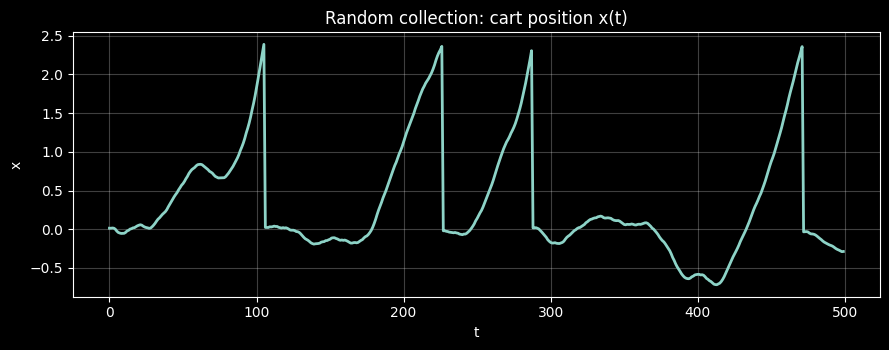

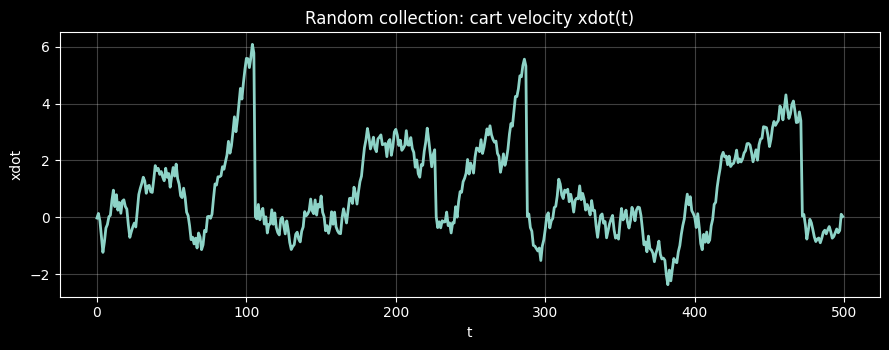

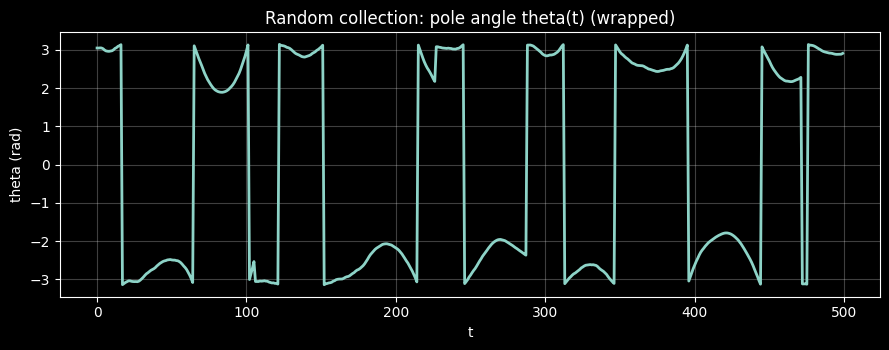

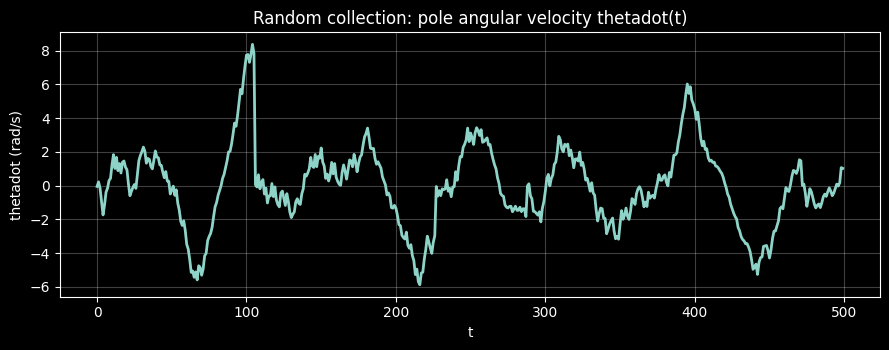

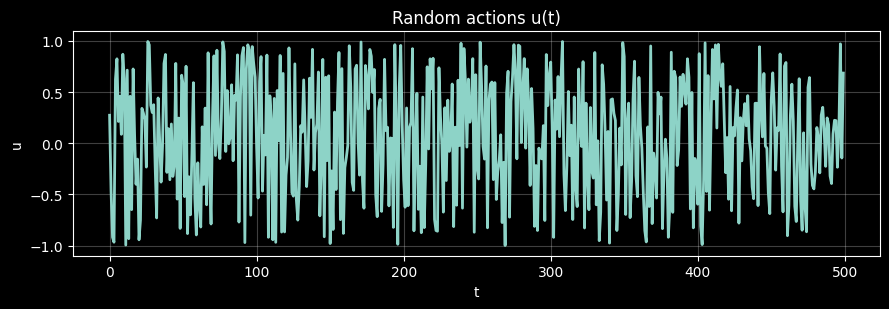

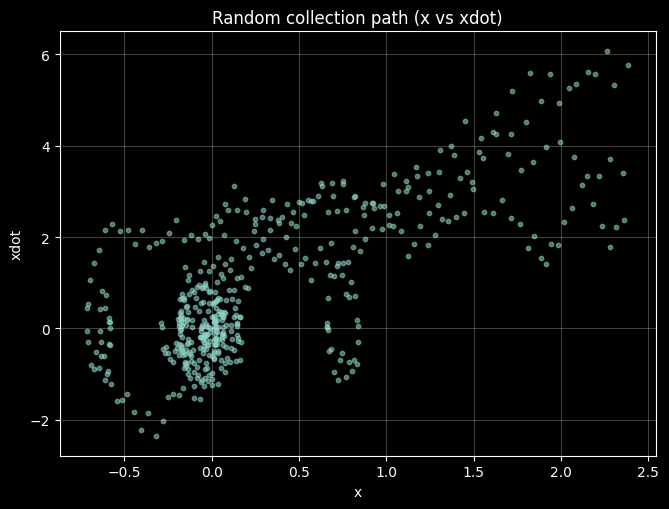

Collected X0 shape: (496, 6)  (6D features)
Collected Y0 shape: (496, 4)  (4D deltas)
Kept=496  Dropped(respawn)=4  Resets=0
Shared init data: X0=(496, 6)  Y0=(496, 4)

--- Method: ExactGP  (seed=0) ---


I0000 00:00:1770661490.215184  170390 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x44d91170


[method=ExactGP] [seed=0] ep=1/4 upd=001 gstep=0039 batch=  40 N=  536 train_sync=  0.082s pred_sync= 0.0053s
[method=ExactGP] [seed=0] ep=1/4 upd=002 gstep=0079 batch=  40 N=  576 train_sync=  0.076s pred_sync= 0.0079s
[method=ExactGP] [seed=0] ep=1/4 upd=003 gstep=0119 batch=  40 N=  616 train_sync=  0.070s pred_sync= 0.0060s
[method=ExactGP] [seed=0] ep=1/4 upd=004 gstep=0159 batch=  39 N=  655 train_sync=  0.070s pred_sync= 0.0068s
[method=ExactGP] [seed=0] ep=1/4 upd=005 gstep=0199 batch=  39 N=  694 train_sync=  0.073s pred_sync= 0.0069s
[method=ExactGP] [seed=0] ep=1/4 upd=006 gstep=0239 batch=  40 N=  734 train_sync=  0.070s pred_sync= 0.0080s
[method=ExactGP] [seed=0] ep=1/4 upd=007 gstep=0279 batch=  39 N=  773 train_sync=  0.074s pred_sync= 0.0073s
[method=ExactGP] [seed=0] ep=1/4 upd=008 gstep=0319 batch=  40 N=  813 train_sync=  0.072s pred_sync= 0.0083s
[method=ExactGP] [seed=0] ep=1/4 upd=009 gstep=0359 batch=  39 N=  852 train_sync=  0.070s pred_sync= 0.0090s
[method=Ex

In [ ]:
# ============================
# Cell 8 — Benchmark driver (multi-run averages) + TRUE synced timing prints
# Prints on EVERY update:
#   - train_sync: wall time for trainer.update_model + device sync
#   - pred_sync:  wall time for pred bench + sync (already syncs via .numpy())
# ============================

import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# ----------------------------
# Method registry
# ----------------------------
def make_trainer(method_name: str, run_seed: int):
    if method_name == "ExactGP":
        return ExactGPTrainer(model_cfg=MODEL_CFG)
    if method_name == "SVGP":
        return SVGPTrainer(model_cfg=MODEL_CFG, svgp_cfg=SVGP_CFG, run_seed=run_seed)
    if method_name == "PALSGP":
        return PALSGPTrainer(model_cfg=MODEL_CFG, palsgp_cfg=PALSGP_CFG, run_seed=run_seed)
    raise ValueError(f"Unknown method: {method_name}")

METHODS = ["ExactGP", "SVGP", "PALSGP"]

# ----------------------------
# Helpers: extract update records + averaging
# ----------------------------
def extract_update_records(log):
    step = np.asarray(log["step"], dtype=np.int64)
    did  = np.asarray(log["did_update"], dtype=bool)
    n    = np.asarray(log["n_data_total"], dtype=np.int64)
    ttr  = np.asarray(log["t_train_s"], dtype=np.float64)
    tpr  = np.asarray(log["t_predbench_s"], dtype=np.float64)

    step_u = step[did]
    n_u    = n[did]
    ttr_u  = ttr[did]
    tpr_u  = tpr[did]
    return dict(step=step_u, n=n_u, t_train=ttr_u, t_pred=tpr_u)

def aggregate_by_step(records_list, y_key):
    buckets = {}
    for rec in records_list:
        xs = rec["step"]; ys = rec[y_key]
        for x, y in zip(xs.tolist(), ys.tolist()):
            buckets.setdefault(int(x), []).append(float(y))
    xs_sorted = np.array(sorted(buckets.keys()), dtype=np.int64)
    mean_y = np.array([np.mean(buckets[int(x)]) for x in xs_sorted], dtype=np.float64)
    std_y  = np.array([np.std(buckets[int(x)])  for x in xs_sorted], dtype=np.float64)
    return xs_sorted, mean_y, std_y

def aggregate_by_n(records_list, y_key):
    buckets = {}
    for rec in records_list:
        xs = rec["n"]; ys = rec[y_key]
        for x, y in zip(xs.tolist(), ys.tolist()):
            buckets.setdefault(int(x), []).append(float(y))
    xs_sorted = np.array(sorted(buckets.keys()), dtype=np.int64)
    mean_y = np.array([np.mean(buckets[int(x)]) for x in xs_sorted], dtype=np.float64)
    std_y  = np.array([np.std(buckets[int(x)])  for x in xs_sorted], dtype=np.float64)
    return xs_sorted, mean_y, std_y

def episode_boundaries():
    return [int(CFG["MAX_STEPS"]) * ep for ep in range(1, int(CFG["N_EPISODES"]))]

# ----------------------------
# Device sync helper (critical for correct timing on GPU)
# ----------------------------
def tf_device_sync():
    """
    Best-effort barrier so timing reflects actual device compute.
    """
    try:
        # TF 2.13+ usually has this
        tf.experimental.async_wait()
    except Exception:
        # Fallback: force a tiny op to materialize
        _ = tf.reduce_sum(tf.random.uniform([1024], dtype=GP_DTYPE)).numpy()

# ----------------------------
# Runner with per-update prints + SYNCED train timing
# ----------------------------
def run_multi_episode_online_ctx_with_prints(trainer, method_name, run_seed, X0, Y0,
                                             start_down=True, edge_respawn=True):
    set_global_seed(run_seed)

    dataset = OnlineDataset(x_dim=6, y_dim=4, dtype=NP_DTYPE)
    dataset.append(np.asarray(X0, dtype=NP_DTYPE), np.asarray(Y0, dtype=NP_DTYPE))

    Xq_bench = make_predbench_queries(run_seed, n=CFG["PRED_BENCH_N"], d=6)

    log = new_episode_log()
    success_list, steps_list = [], []

    global_offset = 0

    # initial build once
    trainer.build_model_from_initial_data(dataset)
    model = trainer.get_model_bundle()

    update_counter = 0

    for ep in range(int(CFG["N_EPISODES"])):
        env = make_env(render_mode=None, seed=run_seed + 1000 * ep,
                       max_episode_steps=int(CFG["MAX_STEPS"]),
                       start_down=start_down, edge_respawn=edge_respawn)

        ubuf = UpdateBuffer(min_batch=int(CFG["MIN_UPDATE_BATCH"]))

        obs, _ = env.reset(seed=run_seed + 1000 * ep)
        hold = 0
        success = False
        u_nom = tf.zeros((MPPI["H"], 1), dtype=GP_DTYPE)

        for t in range(int(CFG["MAX_STEPS"])):
            gstep = int(global_offset + t)

            # plan (same RNG across methods)
            s = np.array(obs_to_state(obs), dtype=NP_DTYPE).reshape(1, 4)
            s_tf = tf.convert_to_tensor(s, dtype=GP_DTYPE)
            seed_pair = tf.constant([int(run_seed), int(gstep)], dtype=tf.int32)

            t0 = time.perf_counter()
            u0, u_nom = mppi_plan_one_step(model, s_tf, u_nom, seed_pair)
            t1 = time.perf_counter()

            a = np.array([float(u0.numpy())], dtype=np.float32)
            obs2, r, term, trunc, info = env.step(a)

            # planning context (PALSGP uses; others ignore)
            if hasattr(trainer, "set_context"):
                trainer.set_context(obs2, u_nom)

            # transition (skip respawned)
            xrow, ydx, ydxd, ydth, ydthd, keep = transition_to_xy(obs, a, obs2, info)
            if keep:
                yrow = np.array([ydx, ydxd, ydth, ydthd], dtype=NP_DTYPE)
                ubuf.push_transition(xrow, yrow)

            # success
            hold, success = check_success(obs2, hold)

            # log defaults
            log["step"].append(gstep)
            log["episode"].append(ep)
            log["reward"].append(float(r))
            log["success"].append(bool(success))
            log["mppi_time_s"].append(float(t1 - t0))

            did_update = False
            n_batch = 0
            n_total = dataset.n
            t_train_sync = 0.0
            t_pred_sync = 0.0

            if ubuf.ready(t_step_1based=t + 1):
                Xnew, Ynew = ubuf.pop_batch()
                if Xnew is not None and Xnew.shape[0] > 0:
                    did_update = True
                    update_counter += 1
                    n_batch = int(Xnew.shape[0])

                    dataset.append(Xnew, Ynew)
                    n_total = dataset.n

                    # ----- SYNCED train timing -----
                    tf_device_sync()
                    t_tr0 = time.perf_counter()
                    _ = trainer.update_model(dataset, Xnew, Ynew)
                    tf_device_sync()
                    t_tr1 = time.perf_counter()
                    t_train_sync = float(t_tr1 - t_tr0)

                    # refresh bundle after update
                    model = trainer.get_model_bundle()

                    # ----- SYNCED pred timing (bench already syncs via .numpy) -----
                    t_pr0 = time.perf_counter()
                    t_pred_sync = bench_predict_time(model, Xq_bench, reps=CFG["PRED_BENCH_REPS"])
                    tf_device_sync()
                    t_pr1 = time.perf_counter()
                    # use the benchmark result as "pred time", but also keep a wall check if you want
                    # wall_pred = float(t_pr1 - t_pr0)

                    print(
                        f"[method={method_name:6s}] [seed={run_seed}] "
                        f"ep={ep+1}/{CFG['N_EPISODES']} upd={update_counter:03d} "
                        f"gstep={gstep:04d} batch={n_batch:4d} N={n_total:5d} "
                        f"train_sync={t_train_sync:7.3f}s pred_sync={t_pred_sync:7.4f}s"
                    )

            log["did_update"].append(bool(did_update))
            log["n_batch"].append(int(n_batch))
            log["n_data_total"].append(int(n_total))
            log["t_train_s"].append(float(t_train_sync))
            log["t_predbench_s"].append(float(t_pred_sync))

            obs = obs2
            if success:
                break

        steps = t + 1
        success_list.append(bool(success))
        steps_list.append(int(steps))

        env.close()
        trainer.after_episode_hook(dataset)
        global_offset += int(CFG["MAX_STEPS"])

    return log, dataset, success_list, steps_list

# ----------------------------
# Run benchmark: paired init data per run seed
# ----------------------------
ALL = {m: {"logs": [], "records": [], "success": [], "steps": []} for m in METHODS}

for run_i, run_seed in enumerate(RUN_SEEDS):
    print(f"\n================= RUN {run_i+1}/{len(RUN_SEEDS)}  seed={run_seed} =================")

    # Shared initial dataset (no rendering in benchmark)
    X0_run, Y0_run, _, _ = collect_random_transitions_rendered_cartpole(
        n_steps=500,
        seed=run_seed,
        max_episode_steps=500,
        start_down=True,
        record_rgb=False,
        frame_stride=2,
        resize=(720, 450),
        fps=20,
        edge_respawn=True,
        respawn_penalty=-2.0,
        drop_respawn_transitions=True,
        verbose=False,
    )
    print(f"Shared init data: X0={X0_run.shape}  Y0={Y0_run.shape}")

    for method in METHODS:
        print(f"\n--- Method: {method}  (seed={run_seed}) ---")
        trainer = make_trainer(method, run_seed=run_seed)

        log, dataset, succ_list, steps_list = run_multi_episode_online_ctx_with_prints(
            trainer=trainer,
            method_name=method,
            run_seed=run_seed,
            X0=X0_run,
            Y0=Y0_run,
            start_down=True,
            edge_respawn=True
        )

        ALL[method]["logs"].append(log)
        ALL[method]["records"].append(extract_update_records(log))
        ALL[method]["success"].append(succ_list)
        ALL[method]["steps"].append(steps_list)

# ----------------------------
# Summary stats
# ----------------------------
print("\n======================== SUMMARY ========================")
for method in METHODS:
    succ = np.asarray(ALL[method]["success"], dtype=np.float64)   # (N_RUNS, N_EPISODES)
    steps = np.asarray(ALL[method]["steps"], dtype=np.float64)

    succ_rate = succ.mean()
    succ_by_ep = succ.mean(axis=0)
    mean_steps = steps.mean()
    mean_steps_by_ep = steps.mean(axis=0)

    print(f"\n{method}:")
    print(f"  Overall success rate: {succ_rate:.3f}")
    print(f"  Success by episode:   {np.round(succ_by_ep, 3)}")
    print(f"  Mean steps/episode:   {mean_steps:.1f}")
    print(f"  Steps by episode:     {np.round(mean_steps_by_ep, 1)}")

# ----------------------------
# Plots
# ----------------------------
bounds = episode_boundaries()

# Plot 1: Train time per update vs global step
plt.figure(figsize=(11, 4))
for method in METHODS:
    xs, my, sy = aggregate_by_step(ALL[method]["records"], y_key="t_train")
    plt.plot(xs, my, label=method)
    plt.fill_between(xs, my - sy, my + sy, alpha=0.15)

for b in bounds:
    plt.axvline(b, linestyle="--", linewidth=1, alpha=0.5)

plt.xlabel("Global timestep (episode-offset timeline)")
plt.ylabel("Update train time (s) [synced]")
plt.title("Training time per update vs timestep (mean ± std over runs)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Total data N vs timestep
plt.figure(figsize=(11, 4))
for method in METHODS:
    xs, my, sy = aggregate_by_step(ALL[method]["records"], y_key="n")
    plt.plot(xs, my, label=method)
    plt.fill_between(xs, my - sy, my + sy, alpha=0.15)

for b in bounds:
    plt.axvline(b, linestyle="--", linewidth=1, alpha=0.5)

plt.xlabel("Global timestep (episode-offset timeline)")
plt.ylabel("Total stored transitions N")
plt.title("Accumulated dataset size vs timestep (mean ± std over runs)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Prediction benchmark time vs timestep
plt.figure(figsize=(11, 4))
for method in METHODS:
    xs, my, sy = aggregate_by_step(ALL[method]["records"], y_key="t_pred")
    plt.plot(xs, my, label=method)
    plt.fill_between(xs, my - sy, my + sy, alpha=0.15)

for b in bounds:
    plt.axvline(b, linestyle="--", linewidth=1, alpha=0.5)

plt.xlabel("Global timestep (episode-offset timeline)")
plt.ylabel("Prediction time (s) on fixed batch [synced]")
plt.title(f"Prediction speed vs timestep (batch={CFG['PRED_BENCH_N']}, median over {CFG['PRED_BENCH_REPS']} reps)")
plt.legend()
plt.tight_layout()
plt.show()

# Extra: Train time vs data size N
plt.figure(figsize=(11, 4))
for method in METHODS:
    xs, my, sy = aggregate_by_n(ALL[method]["records"], y_key="t_train")
    plt.plot(xs, my, label=method)
    plt.fill_between(xs, my - sy, my + sy, alpha=0.15)

plt.xlabel("Total stored transitions N")
plt.ylabel("Update train time (s) [synced]")
plt.title("Training time per update vs dataset size (mean ± std over runs)")
plt.legend()
plt.tight_layout()
plt.show()

# Extra: Pred time vs data size N
plt.figure(figsize=(11, 4))
for method in METHODS:
    xs, my, sy = aggregate_by_n(ALL[method]["records"], y_key="t_pred")
    plt.plot(xs, my, label=method)
    plt.fill_between(xs, my - sy, my + sy, alpha=0.15)

plt.xlabel("Total stored transitions N")
plt.ylabel("Prediction benchmark time (s) [synced]")
plt.title("Prediction benchmark time vs dataset size (mean ± std over runs)")
plt.legend()
plt.tight_layout()
plt.show()

print("\n✅ Cell 8 complete (synced timing).")
